# Bayesian regression for storm erosion prediction
Joshua Simmons 2022

In this notebook, we will fit a Bayesian Linear Regression to predict shoreline change due to coastal storms. This will mirror the simple empirical model developed by:

*Harley, M. D., Turner, I. L., Short, A. D., & Ranasinghe, R. (2009). An empirical model of beach response to storms–SE Australia. In Coasts and Ports (pp. 600-606).*

[Paper available here.](https://www.researchgate.net/profile/Mitchell-Harley/publication/267506992_An_empirical_model_of_beach_response_to_storms_-_SE_Australia/links/5cd8eb9f458515712ea6801f/An-empirical-model-of-beach-response-to-storms-SE-Australia.pdf)

This model is of the form: $\Delta W=aE^b$, where $\Delta W$ is the change in shoreline position, $E$ is the storm energy, and $a$ and $b$ are learnable model parameters.

To provide uncertainty alongside the model prediction, we will use the probabilistic programming language [NumPyro](https://numpyro.readthedocs.io/en/stable/) to fit a Bayesian Linear Regression.

Disclaimers:

- This is an overly simplified analysis for the purpose of demonstrating uncertainty quantification (via Bayesian inference). 
- It was developed purely for practice with NumPyro and streamlit.
- Model predicitons of shoreline change should not be relied upon for real-world application.

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%pdb 1
%matplotlib inline

Automatic pdb calling has been turned ON


## Imports and settings
Everything we need to get started.

In [2]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import sklearn.linear_model as lm

# NumPyro for proabilistic programming
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive

# plotting
from functions import (plot_regression, plot_pareto_points, draw_fit) 
# data
from functions import(load_shoreline_data, load_wave_data, clean_dshoreline_data) 
# analysis
from functions import (find_pareto_front, generate_storm_dataset, calculate_storm_energy)
# models
from functions import (linear_model)

## Load the data

To fit the equation above, we will need:
- Wave data - to calculate storm energy. If this is not previously downloaded, we will fetch this from [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)
- Shoreline data - to calculate shoreline change between storms

As this is a simplified analysis, we will use satellite data derived using [CoastSat](https://github.com/kvos/CoastSat). Speicifically, we will use data from this **amazing** resource ([the CoastSat website](http://coastsat.wrl.unsw.edu.au)) which provides preprocessed shorelines for most of the East Coast of Australia. Again this is for practice with NumPyro and streamlit, so we are not going to think too hard about the suitablity of the data. 

Use the [CoastSat website](http://coastsat.wrl.unsw.edu.au) to select a transect of interest and copy the transect ID (see below) to the `transect_name` variable below. The function `load_shoreline_data` will then download the shoreline data (if not already downloaded). 

![CoastSat website](img/CoastSat_example.png)

Finally we will use the `generate_storm_dataset` function to generate the storm dataset. Using the wave and shoreline data, it will create a dataset for each storm event which has an associated energy (E) and shoreline change (dshl).

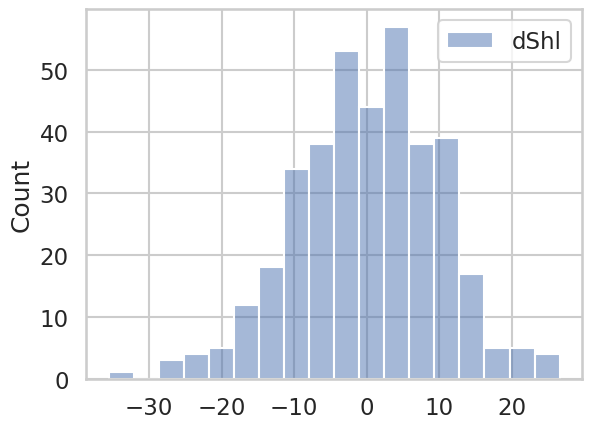

In [6]:
transect_name = 'aus0206-0005'
raw_shl_data = load_shoreline_data(transect_name=transect_name)
raw_wave_data = load_wave_data(transect_name=transect_name)
shl_data = generate_storm_dataset(raw_shl_data, raw_wave_data)

# Check the dsitribution with a quick hist plot
diff_shl_data = raw_shl_data.diff()
diff_shl_data.columns = ['dShl'] 
sns.histplot(diff_shl_data.dropna())
None

## Clean the storm dataset
The [CoastSat](https://github.com/kvos/CoastSat) data have some measurement error, with a reported RMSE of [7.3 to 12.7 m](https://doi.org/10.1016/j.coastaleng.2019.04.004) for some sites. The reality is we are probably pushing the limits of this data for this demonstration, taking a very simplistic approach to modelling it. To make life easier for ourselves, we will clean the data to try and find the equivalent of the barless conditions in the Harley 2009 paper.

![Source: Harley 2009](img/Harley2009_fit.png)
Source: Harley 2009

To make life easier for ourselves, we will look for the Pareto front which defines the upper envelope of observved shoreline change for a given storm energy. We will then use some thresholds to remove all storms which are either too far from the Pareto front, or otherwise deemed unacceptable.

We will need to choose:
- pareto_thresh: the threshold for distance from the Pareto front to be considered a valid storm event
- time_thresh: the maximum time between pre- and post- storm surveys to avoid problems due to low availability of satellite data
- energy_thresh: the minimum energy to be considered a valid event

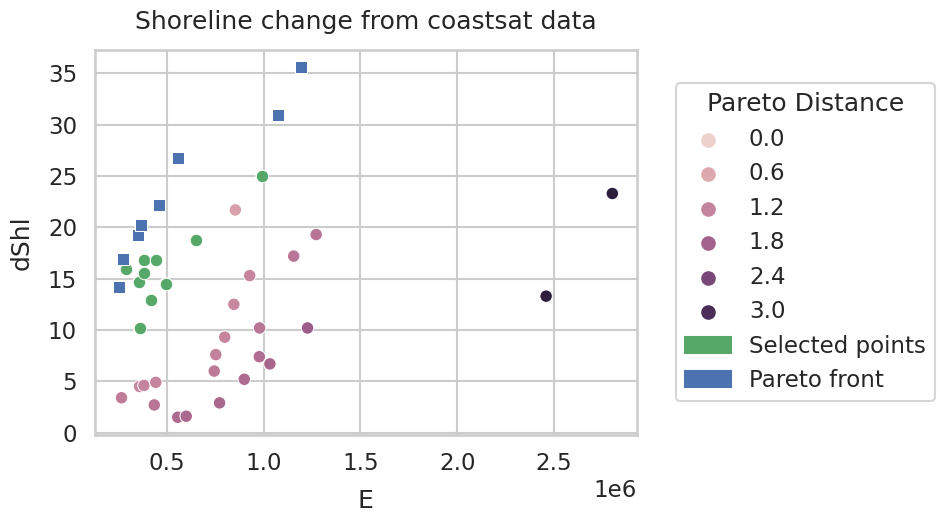

In [4]:
pareto_thresh = 0.75
time_thresh = 100
energy_thresh = 0.25e6

x, y, plotData = clean_dshoreline_data(shl_data, pareto_thresh, time_thresh, energy_thresh)

plot_pareto_points(plotData,pareto_thresh=pareto_thresh)
None

## Fit an ordinary Linear Regression
First we will transform the points to be in log space so that instead of the equation from Harley (2009):
$$\Delta W=aE^b$$
where $a$ and $b$ are the parameters we want to fit, we have:
$$\log(\Delta W)=\log(a)+b*\log(E)$$
where $\log(a)$ and $b$ are the parameters we want to fit (thanks to our handy friends the log laws).

We will then use `scipy.linear_model.LinearRegression` to fit a linear regression.

In [5]:
x_log = np.log(x)
y_log = np.log(y)

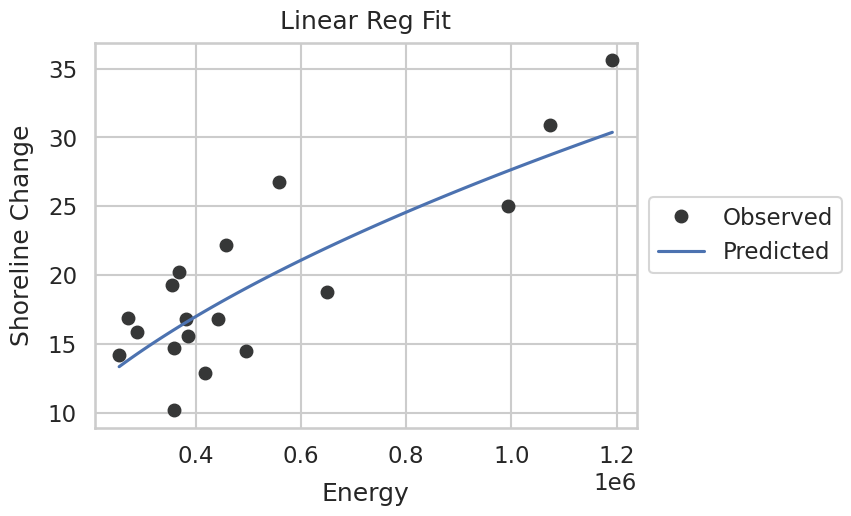

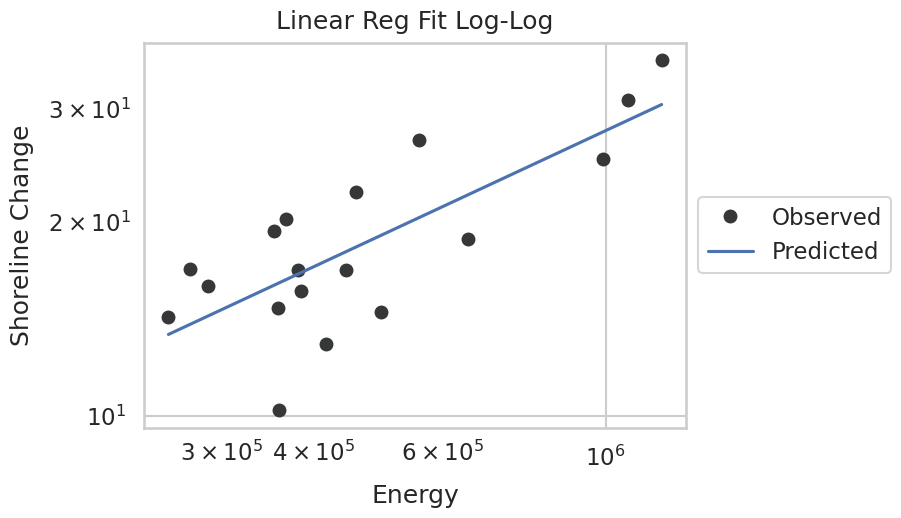

In [6]:
# fit a linear model to the data
freq_model = lm.LinearRegression()
freq_model.fit(x_log.reshape(-1,1),y_log)
# get a sample_x for plotting a line and predict y
sample_x = np.linspace(x.min(),x.max(),101)
y_pred = freq_model.predict(np.log(sample_x).reshape(-1,1))

# Now draw the ft on both orginal scale and log-log
draw_fit(x,y,sample_x,y_pred=np.exp(y_pred),title='Linear Reg Fit')
draw_fit(x,y,sample_x,y_pred=np.exp(y_pred),log_scale=True,title='Linear Reg Fit Log-Log')
None

## Fit a Bayesian Linear Regression using NumPyro

We will fit our Bayesian Linear Regression using NumPyro. Our model looks similar to before:
$$\log(\Delta W)=\log(a)+b*\log(E) + \epsilon$$
$$\epsilon \sim \mathcal{N}(0,\sigma)$$
but here we have explicitly stated that the model fits the data with some random residual or error ($\epsilon$). We can then model this error when fitting to the data, to take into account uncertainty.

We have to make some assumptions about the distribution of our residuals. In our case we will say they follow a normal distribution with a mean of zero (i.e., our linear model fit has no bias) and a standard deviation $\sigma$. $\sigma$ then becomes a third parameter that we will need to sample to determine the variance of our residuals after fitting the model. This is an okay assumption for our very simple case, give our data are in log space and that we don't want to think *too* hard about it for now. 

Now we have to adopt some priors (see above for links to resources on Bayesian approaches) for our three model parameters (we will ditch the log on $a$ for ease of notation). These are: $a$ (Gaussian prior - $\mathcal{N}$), $b$ (Gaussian prior - $\mathcal{G}$) and $\sigma$ (Exponential prior, as we need sigma to be positive - $Exp$).

$$a \sim \mathcal{N}(0,10)$$
$$b \sim \mathcal{N}(1,0.5)$$
$$\sigma \sim Exp(1)$$

We will visualise these further along to check them, but the main thing is trying to ensure that the range of predictions that our modles makes with these priors is reasonable. As an example, we wouldn't expect $b$ to be negative (so a normal distribution centered at zero would be a poor choice) as this would imply that as the energy of a storm increases, the shoreline change it would cause decreases! Otherwise, for this particular case we are going to keep our priors weakly informative, so that we don't have to think too hard.

NumPyro is a probabilistic programming language which helps us to implement a sampling scheme for the paramaters in our model ($log(a)$ and $b$). You can read more about NumPyro [here](https://num.pyro.ai/en/stable/getting_started.html).<br>
For an introduction to Bayesian methods, I thoroughly recommend Richard McElreath's [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) book (via kindle app [here](https://www.amazon.com.au/Statistical-Rethinking-Book-Bayesian-Examples-ebook/dp/B09RW8BYQR/ref=tmm_kin_swatch_0?_encoding=UTF8&qid=&sr=)) with associated code examples. 

In [26]:
def linear_model(energy,dshl=None):
    '''
    Define linear model with priors for the parameters and model error
    Inputs:
        energy: storm energy
        dshl: observed shoreline change
    '''
    # Define priors
    a = numpyro.sample("a",dist.Normal(0, 10))
    b = numpyro.sample("b",dist.Normal(1, 0.5))

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + b * energy
    # store the model prediction before we account for the error
    numpyro.deterministic("mu", mu)
    # and then finally sample so we can compare to our observations
    dshl_modelled = numpyro.sample("dshl_modelled", dist.Normal(mu, sigma), obs=dshl)

Now lets sample from out prior distributions, check what these look like with arviz. You could also check what our predictions look like from the priors to ensure we aren't assuming anything too silly.

In [8]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = Predictive(linear_model, num_samples=100)(
    rng_key_, energy=x_log
)
prior_samples = {k: jnp.expand_dims(v,axis=0) for k, v in prior_samples.items()}
# and put this into arviz for easy plotting
arviz_priors = az.from_dict(
    prior=prior_samples
)
arviz_priors

Inference data with groups:
	> prior

################################################################################
Priors


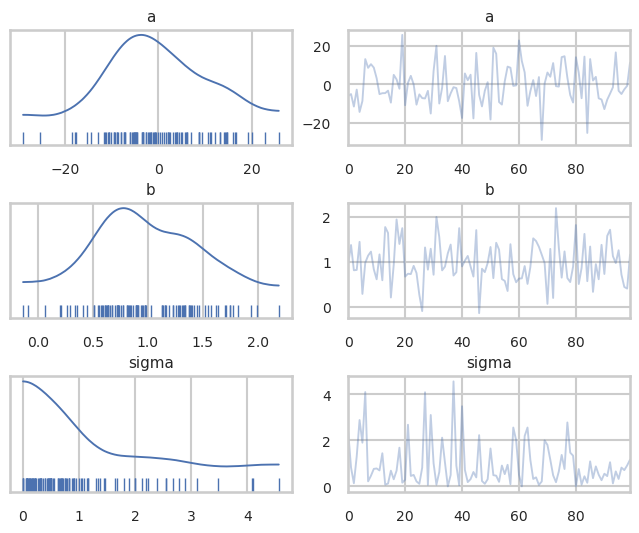

In [9]:
# and now plot the distributions and the simulated data
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    arviz_priors.prior, 
    var_names=['a','b','sigma'],
    figsize=(8,6),
    rug=True,
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

## MCMC Sampling

We will use the No U-Turn Sampler (NUTS) to sample from our posterior distributions. This sampler is popular in many PPLs (Stan, pymc, pyro) and should do the job for us with our mere three parameters. We will sample `num_samples` times form the posterior, with `num_warmup` samples taken and discarded before we start proper.

In [10]:
# settings 
num_samples = 5000
num_warmup = int(0.25 * num_samples)
ci = 0.68

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS)
kernel = NUTS(linear_model)

# define the mcmc wrapper
mcmc_obj = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)

# now run the sampler for num_samples+burnin
mcmc_obj.run(
    rng_key_, energy=x_log, dshl=y_log
)
mcmc_obj.print_summary()
# get the samples which will form our posterior
samples = mcmc_obj.get_samples()

sample: 100%|██████████| 6250/6250 [00:08<00:00, 717.97it/s, 55 steps of size 2.61e-02. acc. prob=0.92]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -4.29      1.56     -4.26     -6.58     -1.46   1083.49      1.00
         b      0.55      0.12      0.55      0.34      0.73   1084.69      1.00
     sigma      0.23      0.04      0.22      0.16      0.29   1292.10      1.00

Number of divergences: 0


We will also get predcitive samples (simulations model + error) which will make more sense in the plots below. We add these to an arviz object for easy plotting and calculate the credible intervals.

In [11]:
# get the samples for predictive uncertainty (our linear model + error)
posterior_predictive = Predictive(linear_model, samples)(
    rng_key_, energy=x_log)

# get the mean model prediciton
mean_mu = jnp.mean(posterior_predictive['mu'], axis=0)
# hpdi is used to compute the credible intervals corresponding to ci
hpdi_mu = hpdi(posterior_predictive['mu'], ci)
hpdi_sim_y = hpdi(posterior_predictive['dshl_modelled'], ci)

arviz_posterior = az.from_numpyro(
    mcmc_obj,
    prior=prior_samples,
    posterior_predictive=posterior_predictive,
)
arviz_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Plot the posterior distributions for our three parameters and check that they look reasonable. We also want to check the traces (right hand plots) to ensure everything has gone well during the MCMC sampling. Again we won't worry too much about that for this fairly simple case. Notice as well how far our posteriors have deviated from our priors based on the data we have observed.

################################################################################
Posterior


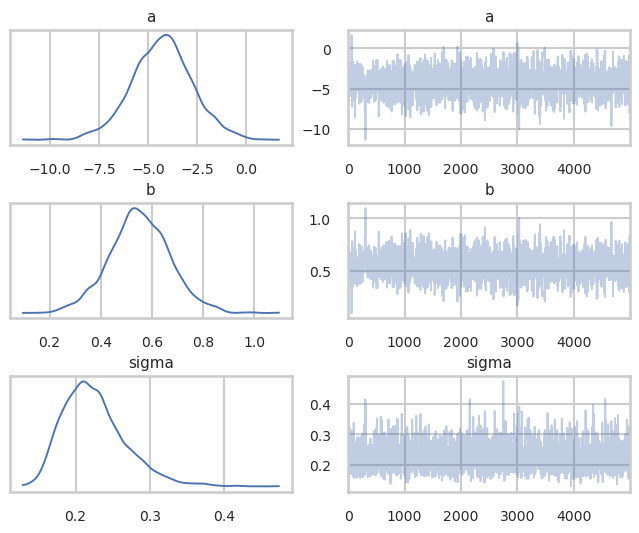

In [12]:
print('#'*80)
print('Posterior')
az.plot_trace(
    arviz_posterior,
    var_names=['a','b','sigma'],
    figsize=(8,6),
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

## Plot the results

We can now plot our model predictions with uncertainty for our selected credible interval (`ci`) - say 68%. Notice that we plot two uncertainty bands, the first is the credible interval for our linear model (blue bands). Essentially, what are range of slopes and intercepts that linear fit could take, reflecting the posteriors for  parameters $a$ and $b$ as we are uncertain of their exact value. 

However, we also have the $\sigma$ parameter. The predictive uncertainty (credible interval given by the orange bands) incorporates model uncertainty and the error ($\epsilon$) which describes our data (which we have assumed to be of the form $\mathcal{N}(0,\sigma)$). Here we are simulating possible values of actual data points, as opposed to just the range of possible linear regression lines. These bands should include approximately 68% of our data points, i.e. approximately matching the `ci` we have chosen.

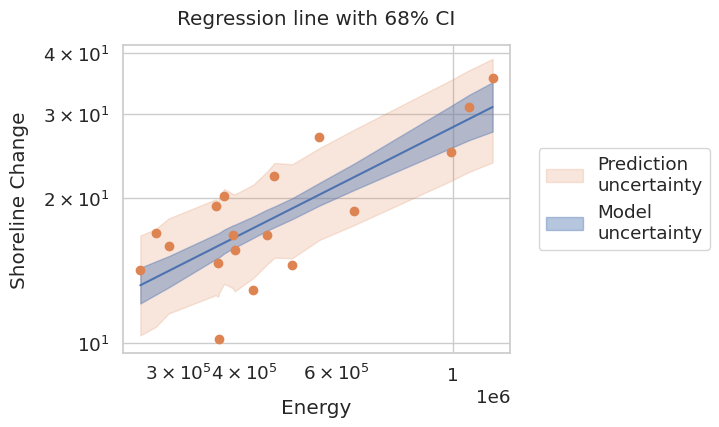

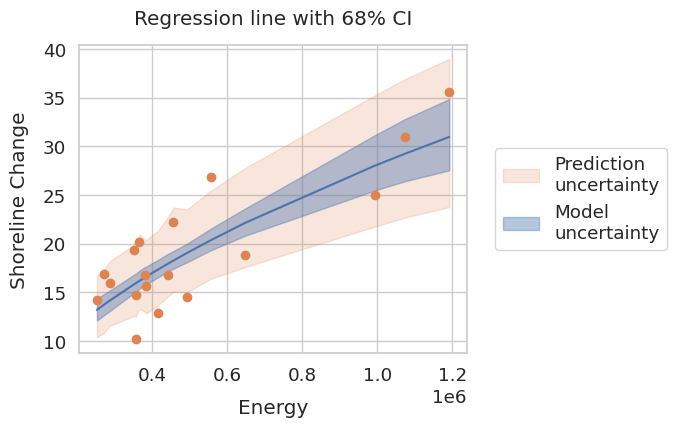

In [13]:
# Now we will plot the results in log-log scale and on the original scale
plot_regression(np.exp(x_log), np.exp(y_log), np.exp(x_log), np.exp(mean_mu), np.exp(hpdi_mu), np.exp(hpdi_sim_y), ci, log_scale=True)
plot_regression(np.exp(x_log), np.exp(y_log), np.exp(x_log), np.exp(mean_mu), np.exp(hpdi_mu), np.exp(hpdi_sim_y), ci)

# Predict for new events
Finally we want to be able to predict the shoreline change for a new event, given the energy of this event. You can either:

- specify the energy directly
- or give a maxiumum $H_{sig}$ for the event and associate storm length (in hours). Using this, the storm energy will be calculated for a triangular storm event. We will assume the wave height to be defined as a storm is $H_{sig} = 3$ m and the storm will increase in wave height to peak halfway through the event with the specified maximum $H_{sig}$.

In [33]:
# Either specify event energy
event_energy = 0.8e6

# make a prediction with our model
event_predictive = Predictive(linear_model, samples)(
    rng_key_, energy=np.log(np.array(event_energy)))

# Print the prediction
print('Storm Energy: {:.2E}'.format(event_energy))
print('Model Mean predicted shoreline change: {:.2f} m'.format(np.exp(jnp.mean(event_predictive['mu']))))
print('Model {:.0f}% Credibilty Interval: {:.2f} - {:.2f} m'.format(ci*100,*np.exp(hpdi(event_predictive['mu'], ci))))
print('Prediction {:.0f}% Credibilty Interval: {:.2f} - {:.2f} m'.format(ci*100,*np.exp(hpdi(event_predictive['dshl_modelled'], ci))))


Storm Energy: 8.00E+05
Model Mean predicted shoreline change: 24.84 m
Model 68% Credibilty Interval: 22.88 - 26.89 m
Prediction 68% Credibilty Interval: 19.57 - 31.25 m


In [36]:
# or specify hsig_max and storm_duration
hsig_max = 6.0 # m
storm_duration = 48 # hours

# calculate based on an assumed triangular storm
event_energy = calculate_storm_energy(hsig_max, storm_duration)

# make a prediction with our model
event_predictive = Predictive(linear_model, samples)(
    rng_key_, energy=np.log(np.array(event_energy)))

# Print the prediction
print('Storm Energy: {:.2E} with hsig_max = {:.2f} m and storm_duration = {:.0f} hrs'.format(event_energy, hsig_max, storm_duration))
print('Model Mean predicted shoreline change: {:.2f} m'.format(np.exp(jnp.mean(event_predictive['mu']))))
print('Model {:.0f}% Credibilty Interval: {:.2f} - {:.2f} m'.format(ci*100,*np.exp(hpdi(event_predictive['mu'], ci))))
print('Prediction {:.0f}% Credibilty Interval: {:.2f} - {:.2f} m'.format(ci*100,*np.exp(hpdi(event_predictive['dshl_modelled'], ci))))


Storm Energy: 6.24E+05 with hsig_max = 6.00 m and storm_duration = 48 hrs
Model Mean predicted shoreline change: 21.66 m
Model 68% Credibilty Interval: 20.39 - 23.01 m
Prediction 68% Credibilty Interval: 17.38 - 27.43 m
